In [1]:
# ! git clone https://github.com/ultralytics/yolov5 # clone repo
# ! pip install -U -r ../input/yolov5/yolov5-master/requirements.txt

In [2]:
import sys
sys.path.insert(0, "../input/yolov5master")
sys.path.insert(0, "../working/yolov5/")



In [3]:
import numpy as np
import pandas as pd
import os
import warnings
import random
import torch 
from torch import nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
import tokenizers
from transformers import RobertaModel, RobertaConfig
import ast
import argparse
import matplotlib.pyplot as plt

from PIL import Image

import PIL

import torch.distributed as dist
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms, utils
import torchvision


warnings.filterwarnings('ignore')

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [4]:
! mkdir data
! mkdir data/labels
! mkdir data/images
! mkdir data/images/train
! mkdir data/images/val
! mkdir data/labels/train
! mkdir data/labels/val

# make dir 

In [5]:
TRAIN_PATH = "../input/global-wheat-detection/train"
TRAIN_CSV  = "../input/global-wheat-detection/train.csv"

# Dataset yaml

In [6]:
filename = "../working/data/gwd.yaml"
file = open(filename,'w')
file.writelines( "train: ../working/data/images/train\n" )
file.writelines( "val: ../working/data/images/val\n" )
file.writelines("nc: 1\n")
file.writelines("names: ['wheat']")
file.close()


# Setup label file dataset

<bound method NDFrame.head of          image_id  width  height                         bbox     source
0       b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]    usask_1
1       b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]    usask_1
2       b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]    usask_1
3       b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]    usask_1
4       b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]    usask_1
...           ...    ...     ...                          ...        ...
147788  5e0747034   1024    1024    [64.0, 619.0, 84.0, 95.0]  arvalis_2
147789  5e0747034   1024    1024  [292.0, 549.0, 107.0, 82.0]  arvalis_2
147790  5e0747034   1024    1024  [134.0, 228.0, 141.0, 71.0]  arvalis_2
147791  5e0747034   1024    1024   [430.0, 13.0, 184.0, 79.0]  arvalis_2
147792  5e0747034   1024    1024   [875.0, 740.0, 94.0, 61.0]  arvalis_2

[147793 rows x 5 columns]>
Num of fig =  3422 3422
bbox avg num = 43.18907071887785  max num 

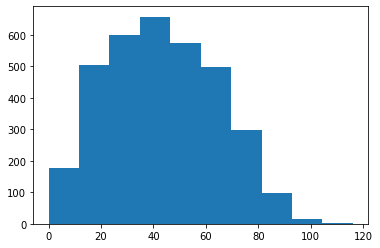

In [7]:
# get name and id 
name_list = os.listdir(TRAIN_PATH)
id_list = [name[:-4] for name in name_list]
df_accumulate = {}
for i,name in enumerate(name_list):
    df_accumulate[name] = [id_list[i], [],[]]  # dict store[ path, list of bbox, source ]

# read csv 
df = pd.read_csv(TRAIN_CSV, converters = {'bbox':ast.literal_eval})
print( df.head ) 
df = df.values
 # accumulate bounding box for each graph 
bbox_num = []
for i, item in enumerate(df):
    df_accumulate[item[0]+".jpg"][1].append( item[3] )
    if( item[1] != 1024 or item[2] != 1024):
        print("Invalid image size")
    
for i, name in enumerate(name_list):
    bbox_num.append( len( df_accumulate[name][1]) )

bbox_num = np.asarray(bbox_num)
print("Num of fig = ", len(name_list), len(df_accumulate))
print("bbox avg num =", np.mean(bbox_num), " max num = ", np.max(bbox_num), " min num = ", np.min(bbox_num))
print("num of fig with zero bbox:", np.sum( bbox_num == 0 ))
plt.hist(bbox_num)
plt.show()


In [8]:
TRAIN_index = '../input/wheatoutput1/train_index.csv'
VAL_index = '../input/wheatoutput1/val_index.csv'
TRAIN_index_df = pd.read_csv(TRAIN_index, converters = {'bbox':ast.literal_eval})
train_index = np.squeeze(TRAIN_index_df.values) 
VAL_index_df = pd.read_csv(VAL_index, converters = {'bbox':ast.literal_eval})
val_index =  np.squeeze(VAL_index_df.values)
#print( train_index ) 

In [9]:
# import random
# index_ = np.asarray( range(0,len(name_list)) )
# random.shuffle(index_)
# index_ = np.asarray(index_)

# KFOLD = 10 # divide into train and val
# num_of_val = int(len(index_)/KFOLD)
# val_index = index_[0:num_of_val]
# train_index = index_[num_of_val:]

# val_index_df = pd.DataFrame(val_index, columns=['val_index'])
# val_index_df.to_csv('val_index.csv', index=False)
# val_index_df.head()

# train_index_df = pd.DataFrame(train_index, columns=['train_index'])
# train_index_df.to_csv('train_index.csv', index=False)
# train_index_df.head()

In [10]:
from shutil import copyfile

label_dir = "../working/data/labels/train"
image_dir = "../working/data/images/train"
for it in train_index:
        
    img_name = name_list[it]
    label_name = name_list[it][0:-4] +".txt" 
    copyfile(os.path.join(TRAIN_PATH, img_name), os.path.join(image_dir, img_name) )
    # copy img 
    
    bbox_list = df_accumulate[img_name][1]
    file = open(os.path.join(label_dir, label_name), 'w')
    for bbox in bbox_list:
        xcenter = ( bbox[0] + 0.5 * bbox[2] )/1024.0
        ycenter = ( bbox[1] + 0.5 * bbox[3] )/1024.0
        w,h = bbox[2]/1024.0, bbox[3]/1024.0
        file.writelines( "0 "+str(xcenter)+" "+str(ycenter)+" "+str(w)+" "+str(h) +"\n" )
    file.close()
    # write lable file 
    

label_dir = "../working/data/labels/val"
image_dir = "../working/data/images/val"
for it in val_index:
        
    img_name = name_list[it]
    label_name = name_list[it][0:-4] +".txt" 
    copyfile(os.path.join(TRAIN_PATH, img_name), os.path.join(image_dir, img_name) )
    # copy img to train
    
    bbox_list = df_accumulate[img_name][1]
    file = open(os.path.join(label_dir, label_name), 'w')
    for bbox in bbox_list:
        xcenter = ( bbox[0] + 0.5 * bbox[2] )/1024.0
        ycenter = ( bbox[1] + 0.5 * bbox[3] )/1024.0
        w,h = bbox[2]/1024.0, bbox[3]/1024.0
        file.writelines( "0 "+str(xcenter)+" "+str(ycenter)+" "+str(w)+" "+str(h) +"\n" )
    file.close()
    # write lable file 
    

    

# Model yaml

In [11]:
file_in = open("../input/yolov5master/models/yolov5s.yaml")
file_out = open("../working/model.yaml",'w')
while(1):
    line = file_in.readline()
    if not line:
        break
    if(line.find("nc:") >=0):
        file_out.writelines("nc: 1\n")
    else:
        file_out.writelines(line)
    
file_out.close()
file_in.close()


# Train 

In [12]:
! python ../input/yolov5master/train.py --img 1024 --batch 16 --epochs 110 --data ../working/data/gwd.yaml --cfg ../working/model.yaml --weights ../input/wheatoutput1/last-60.pt 

Apex recommended for faster mixed precision training: https://github.com/NVIDIA/apex
{'lr0': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'giou': 0.05, 'cls': 0.58, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.014, 'hsv_s': 0.68, 'hsv_v': 0.36, 'degrees': 0.0, 'translate': 0.0, 'scale': 0.5, 'shear': 0.0}
Namespace(adam=False, batch_size=16, bucket='', cache_images=False, cfg='../working/model.yaml', data='../working/data/gwd.yaml', device='', epochs=110, evolve=False, img_size=[1024], multi_scale=False, name='', noautoanchor=False, nosave=False, notest=False, rect=False, resume=False, single_cls=False, weights='../input/wheatoutput1/last-60.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

2020-06-22 01:55:05.041729: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Start Tensorboard with "tensorboard --logdir=r

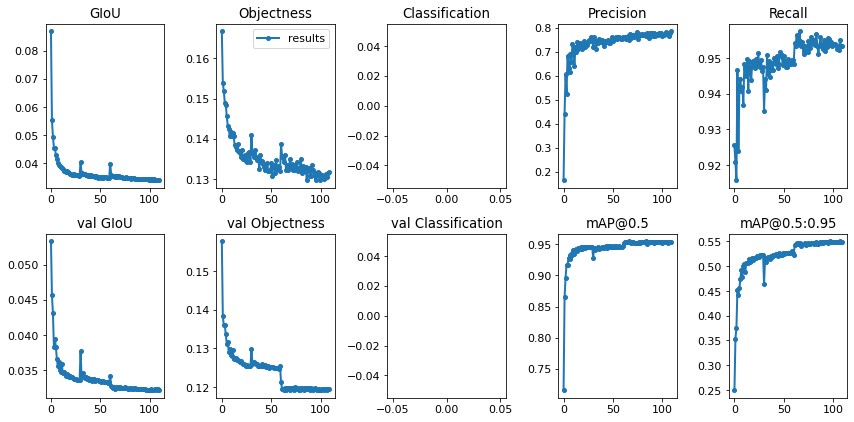

In [13]:
from utils.utils import plot_results
plot_results()

# val test